# Empréstimo Pessoal (Thera Bank)

**Este projeto analisa o caso do Thera Bank, uma instituição financeira que busca aumentar a conversão de seus clientes de depósito (passivos) em clientes de empréstimos pessoais. Em uma campanha anterior, o banco obteve uma taxa de conversão de aproximadamente 9%, considerada positiva pela administração. Esse resultado motivou o departamento de marketing de varejo a investir em estratégias de marketing mais direcionado, com o objetivo de elevar a taxa de sucesso e, ao mesmo tempo, otimizar os custos da campanha.**

## EDA- Exploração e Análise dos Dados

### Importação das bibliotecas e carregamento dos dados para o workspace

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
from sklearn.feature_selection import mutual_info_classif

In [123]:
sns.set_theme()

In [124]:
path_data = 'Files/Bank_Personal_Loan_Data.csv'
data = pd.read_csv(path_data)

In [125]:
data.head(10)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1/60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1/50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1/00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2/70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1/00,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0/40,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1/50,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0/30,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0/60,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8/90,3,0,1,0,0,0,0


### Verificação da consistência dos dados

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  5000 non-null   int64 
 1   Age                 5000 non-null   int64 
 2   Experience          5000 non-null   int64 
 3   Income              5000 non-null   int64 
 4   ZIP Code            5000 non-null   int64 
 5   Family              5000 non-null   int64 
 6   CCAvg               5000 non-null   object
 7   Education           5000 non-null   int64 
 8   Mortgage            5000 non-null   int64 
 9   Personal Loan       5000 non-null   int64 
 10  Securities Account  5000 non-null   int64 
 11  CD Account          5000 non-null   int64 
 12  Online              5000 non-null   int64 
 13  CreditCard          5000 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 547.0+ KB


In [127]:
print(f'Quantidade de células nulas por coluna \n{data.isna().sum()}')

Quantidade de células nulas por coluna 
ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


In [128]:
print(f'Quantidade de registros duplicados: {int(data.duplicated().sum())}')

Quantidade de registros duplicados: 0


In [129]:
data.describe()

,ID,Age,Experience,Income,ZIP Code,Family,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


A coluna ID é um campo de identificação e não traz informação para prever a variável alvo, logo será removida do dataset

In [130]:
data.drop('ID', axis=1, inplace=True)

Observamos que alguns registros apresentam valores negativos na coluna 'Experience' (anos de experiência). Será necessário avaliar se esses valores representam erros de digitação ou informações inconsistentes. Para isso, analisaremos a relação dessa variável com as demais features e verificaremos se os valores negativos seguem algum padrão específico antes de decidir se devem ser removidos ou corrigidos.

In [131]:
data_filter = data[data['Experience']<0]

print(f'Quantidade de registros com experiência negativa: {len(data_filter)}')
data_filter.head()

Quantidade de registros com experiência negativa: 52


,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
89,25,-1,113,94303,4,2/30,3,0,0,0,0,0,1
226,24,-1,39,94085,2,1/70,2,0,0,0,0,0,0
315,24,-2,51,90630,3,0/30,3,0,0,0,0,1,0
451,28,-2,48,94132,2,1/75,3,89,0,0,0,1,0
524,24,-1,75,93014,4,0/20,1,0,0,0,0,1,0


O campo CCAvg representa a média de gastos mensais no cartão de crédito (em milhares de dólares). Originalmente, os valores estavam em uma notação textual confusa, como 1/70, que corresponde a 1.70 × 1000 dólares. Para facilitar a análise, os valores foram convertidos substituindo o caractere / por . e transformados em números decimais (float64), mantendo a unidade em milhares de dólares.

In [132]:
data['CCAvg'] = data['CCAvg'].str.replace('/','.').astype(float)
data['CCAvg'] = data['CCAvg']*1000

O campo Mortgage corresponde ao valor do financiamento da casa de um cliente em milhares de dólars, vou normalizar para o valor literal em dólares.

In [133]:
data['Mortgage'] = data['Mortgage']*1000

Nossos dados agora se organizam da seguinte maneira

Conteúdo das Colunas

| Coluna                 | Descrição                                                                |
|------------------------|--------------------------------------------------------------------------|
| ID                     | ID do cliente                                                            |
| Age                    | Idade do cliente (em anos completos)                                     |
| Experience             | Anos de experiência profissional                                         |
| Income                 | Renda anual do cliente                                                   |
| ZIP Code               | Código postal do endereço                                                |
| Family                 | Tamanho da família do cliente                                            |
| CCAvg                  | Média de gastos mensais no cartão de crédito                             |
| Education              | Nível educacional (1 = graduação, 2 = pós-graduação, 3 = avançado)       |
| Mortgage               | Valor do financiamento da casa, se houver                                |
| Personal Loan          | Cliente aceitou o empréstimo pessoal oferecido na última campanha?       |
| Securities Account     | Cliente possui conta de valores mobiliários no banco?                    |
| CD Account             | Cliente possui conta de certificado de depósito (CD) no banco?           |
| Online                 | Cliente utiliza serviços de internet banking?                            |
| CreditCard             | Cliente possui cartão de crédito emitido pelo banco UniversalBank?       |



In [134]:
data.head(10)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1600.0,1,0,0,1,0,0,0
1,45,19,34,90089,3,1500.0,1,0,0,1,0,0,0
2,39,15,11,94720,1,1000.0,1,0,0,0,0,0,0
3,35,9,100,94112,1,2700.0,2,0,0,0,0,0,0
4,35,8,45,91330,4,1000.0,2,0,0,0,0,0,1
5,37,13,29,92121,4,400.0,2,155000,0,0,0,1,0
6,53,27,72,91711,2,1500.0,2,0,0,0,0,1,0
7,50,24,22,93943,1,300.0,3,0,0,0,0,0,1
8,35,10,81,90089,3,600.0,2,104000,0,0,0,1,0
9,34,9,180,93023,1,8900.0,3,0,1,0,0,0,0


In [135]:
target_feature = ["Personal Loan"]
id_features = ["ID", "ZIP Code"]
numeric_features = ["Age", "Experience", "Income", "CCAvg", ]
categorical_features = ["Family", "Education", "Securities Account", "CD Account", "Online", "CreditCard"]

### Distribuição dos dados

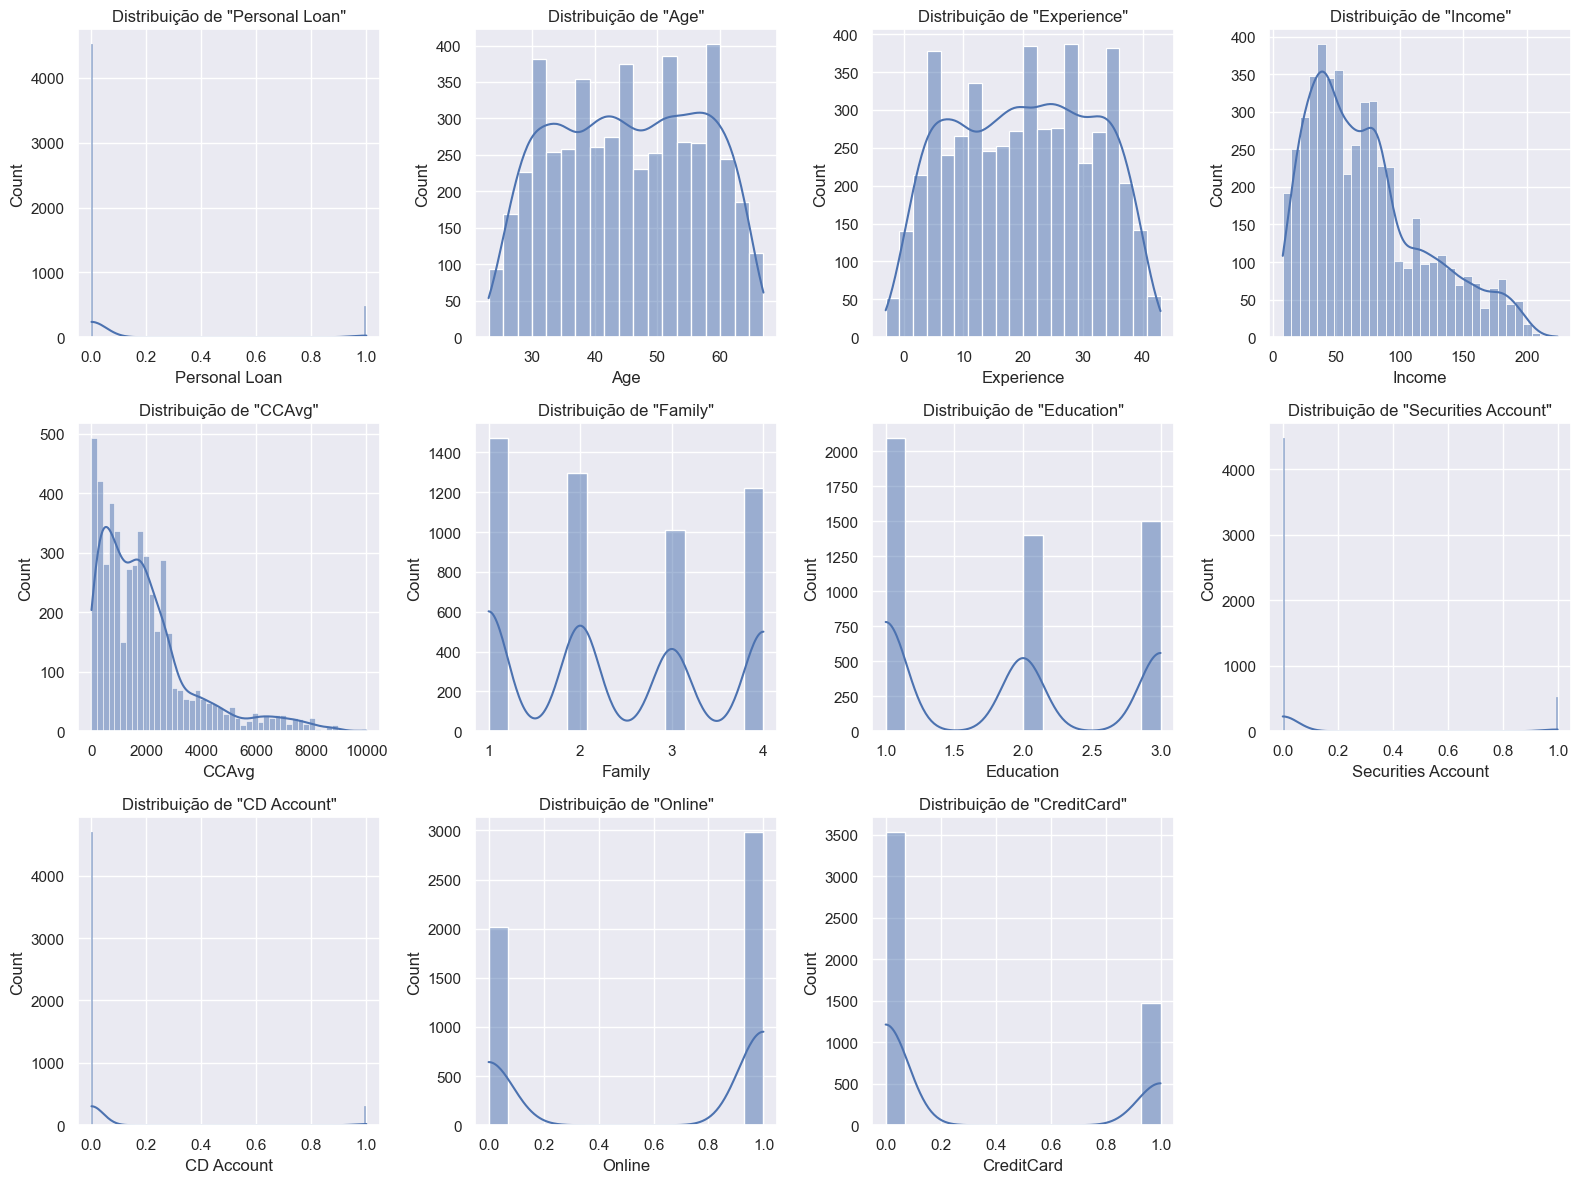

In [137]:
features_analized = target_feature + numeric_features + categorical_features
ncols = 4
nrows = len(features_analized)//ncols+1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axs = axs.flatten()

for i, feature in enumerate(features_analized):
    sns.histplot(x=data[feature], ax=axs[i], kde=True)
    axs[i].set_title(f"Distribuição de \"{feature}\"")

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
    

### Outliers

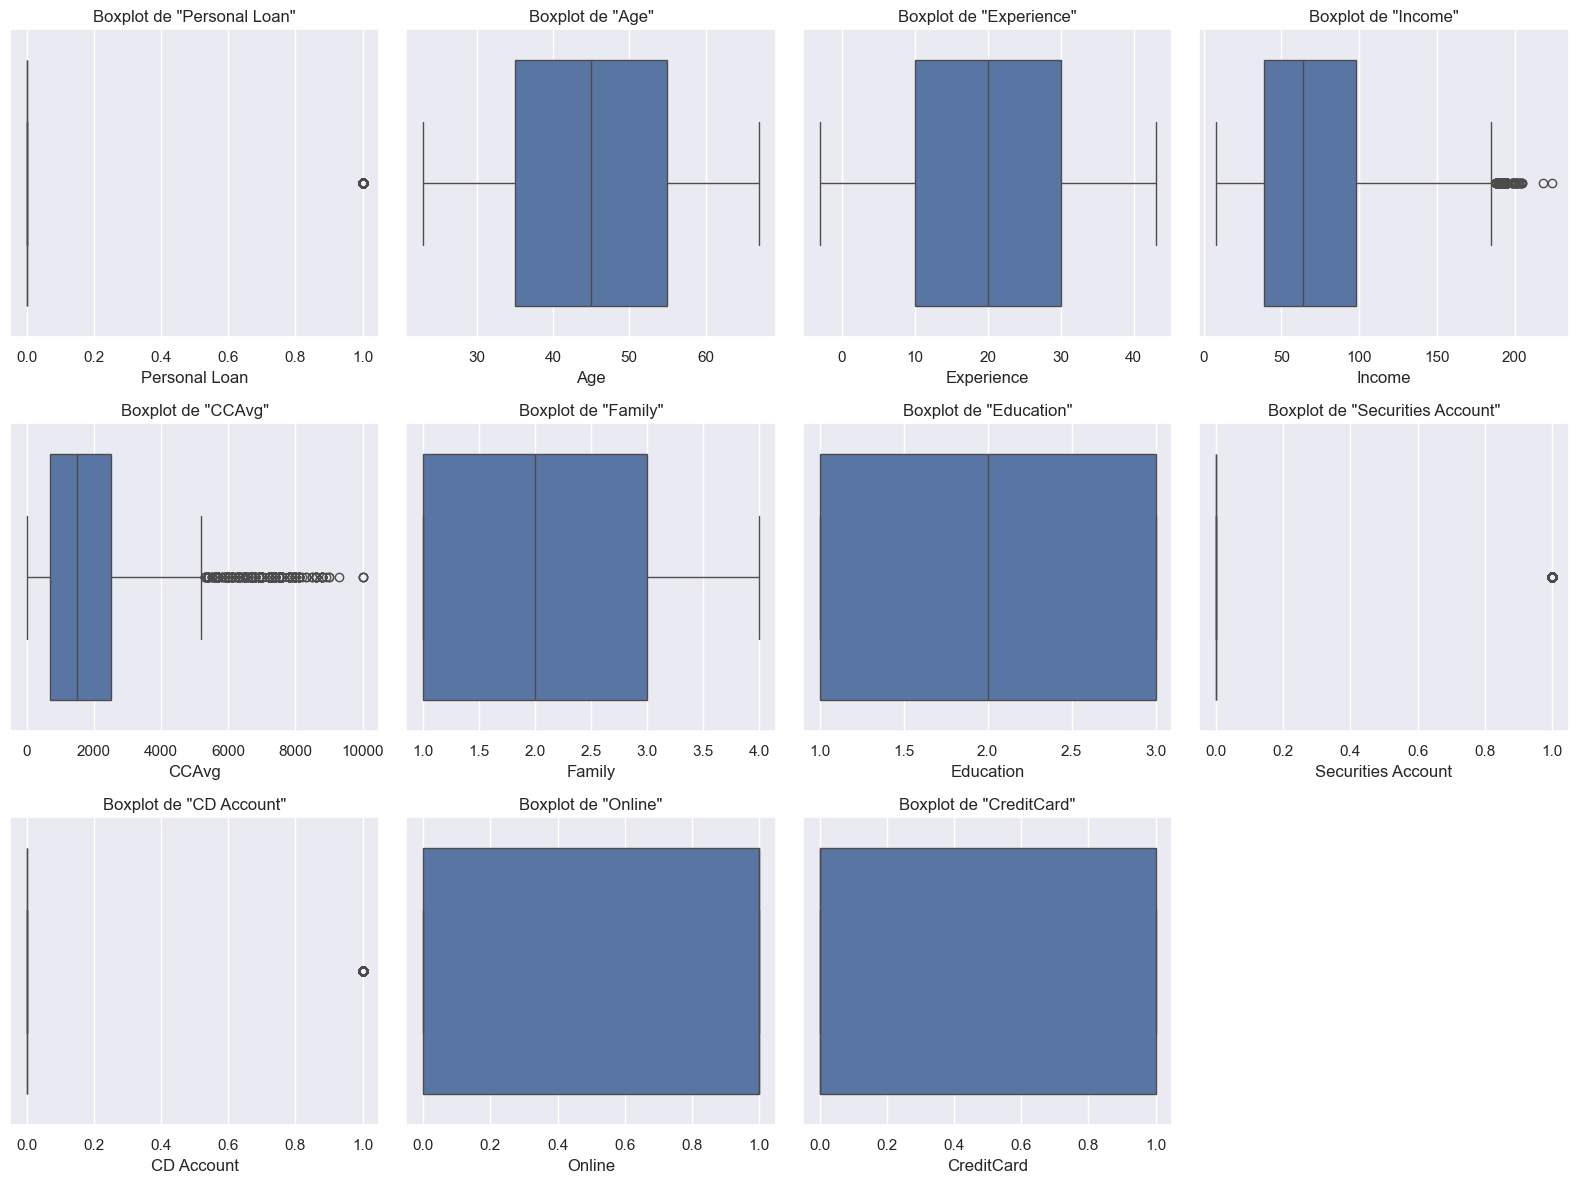

In [138]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axs = axs.flatten()

for i, feature in enumerate(features_analized):
    sns.boxplot(x=data[feature], ax=axs[i])
    axs[i].set_title(f"Boxplot de \"{feature}\"")

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
    

### Análise de correlação

- As variáveis "Experience" e "Age" tem uma relação muito forte (ρ=0.99), ou seja, são variáveis redundantes. Podemos remover uma delas sem perca de informação relevante.
- "CCAvg" e "Income" tem ρ=0.65, indicando um comportamento semelhante entre a média de gastos mensais no cartão e a renda do cliente. É de se esperar que quanto mais alguém ganha, mais ele gasta.
- "Personal Loan" (nossa variável alvo) e "Income" tem ρ=0.5, dando indícios de que a variável "Income" será muito importante para a predição de interesse, bem como CCAvg com ρ=0.37

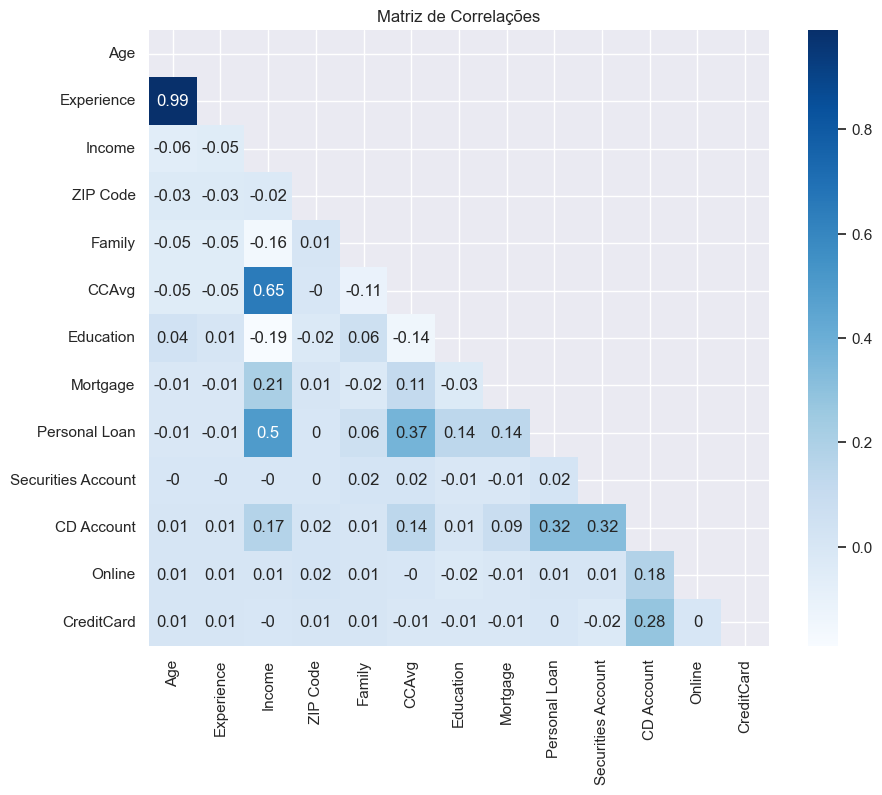

In [136]:
corr_matrix = data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(round(corr_matrix,2), mask=mask, cmap='Blues', annot=True)
plt.title('Matriz de Correlações')
plt.show()

### Relação das variáveis numéricas com a variável alvo 

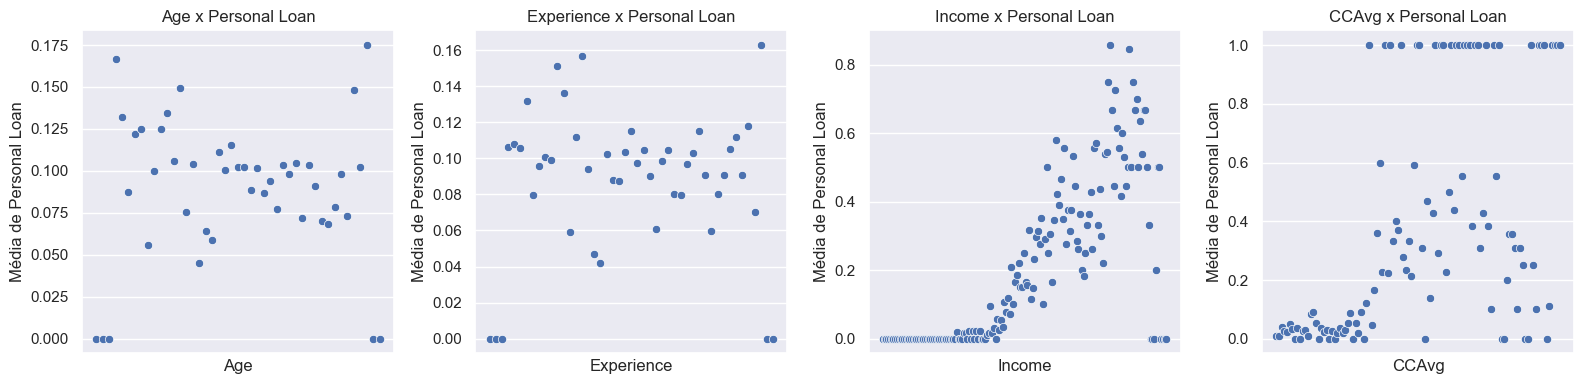

In [139]:
fig, axs = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(4*len(numeric_features), 4))
axs = axs.flatten()

for i, feature in enumerate(numeric_features):
    relation = data.groupby(feature)[target_feature[0]].mean()

    sns.scatterplot(x=relation.index.astype(str), y=relation.values, ax=axs[i])
    axs[i].set_title(f'{feature} x {target_feature[0]}')
    axs[i].set_xlabel(feature)
    axs[i].set_xticks([])
    axs[i].set_ylabel(f'Média de {target_feature[0]}')

plt.tight_layout()
plt.show()

Avaliando a relação das variáveis, conseguimos extrair alguns padrões.

- "Age" e "Experience", como vimos antes tem correlação (ρ=0.99), logo a distribuição e ganho de informação destas variáveis são semelhantes. O gráfico mostra que essas variáveis não seguem um padrão explicíto, ou seja, é possível que estas variáveis não apresentam valor preditivo considerável.
- "Income" e "CCAvg" são variáveis muito informativas para a nossa variável alvo, como visto na matriz de correlações e no gráfico de pontos.

### Relação das variáveis categóricas com a variável alvo 

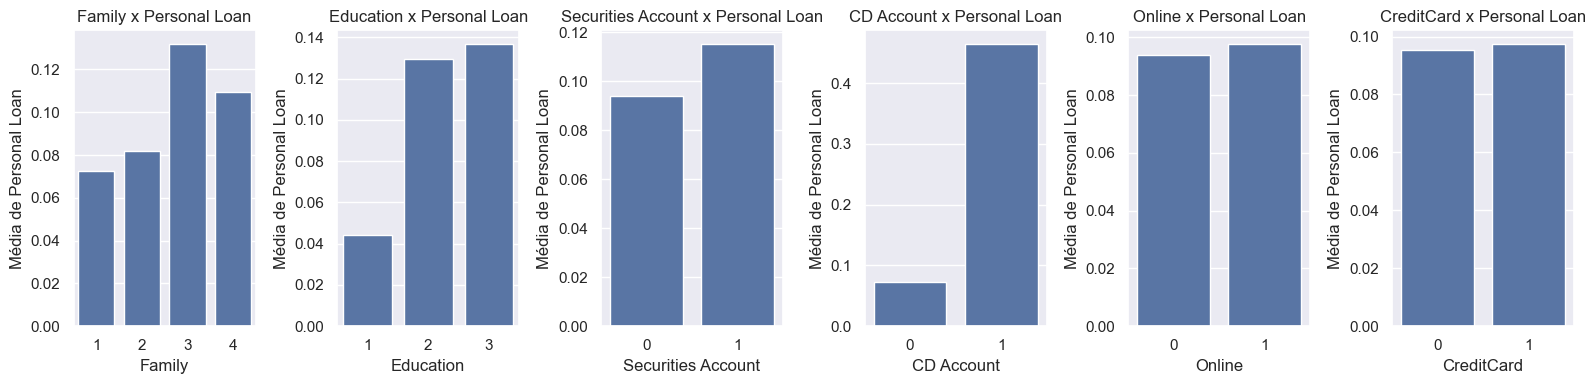

In [140]:
fig, axs = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(4*len(numeric_features), 4))
axs = axs.flatten()

for i, feature in enumerate(categorical_features):
    relation = data.groupby(feature)[target_feature[0]].mean()

    sns.barplot(x=relation.index.astype(str), y=relation.values, ax=axs[i])
    axs[i].set_title(f'{feature} x {target_feature[0]}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel(f'Média de {target_feature[0]}')

plt.tight_layout()
plt.show()

Perfil de pessoas mais propícias a aceitar a oferta

- Famílias com 3 membros
- Pessoas com nível educacional avançada / pós graduadas
- Possui conta de valores mobiliários no banco
- Possui certificado de depósito no banco

Analisando mais afundo o ganho de informação, podemos extrair alguns padrões

- As variáveis "Online" e "CreditCard", que indicam o uso de ferramentas na internet do banco e se ela possui cartão de crédito emitido pelo Banco Universal, respectivamente, não apresentam diferenças significativas entre aceitos e não aceitos da proposta.
- A variável "CD Account", que indica se a pessoa possui certificado de depósito no banco tem um ganho de informação relevante, onde cerca de 47% das pessoas que possuem o certificado e 8% que não possuem, aceitaram a proposta.
- "Family" e "Education" que são a quantidade de membros na família e nível educacional tem algum ganho de informação.


### Ganho de Informação

In [144]:
features = numeric_features + categorical_features
x = pd.get_dummies(data[features])
y = data[target_feature[0]]

mi = mutual_info_classif(x, y, discrete_features='auto')

mi_data = pd.DataFrame({
    "Feature": x.columns,
    "Mutual Information" : mi
}).sort_values("Mutual Information", ascending=False)

print(mi_data)

              Feature  Mutual Information
2              Income            0.130180
3               CCAvg            0.094977
7          CD Account            0.027662
5           Education            0.009286
1          Experience            0.005665
0                 Age            0.003535
4              Family            0.002054
8              Online            0.000923
6  Securities Account            0.000000
9          CreditCard            0.000000


Como esperado, temos renda atual por ano, gasto no cartão de crédito e se possui certificado de depósito no banco como principais variáveis informativas para determinar o público alvo.